# 20 News dataset

This data set is a collection of 20,000 messages, collected from 20 different netnews newsgroups. One thousand messages from each of the twenty newsgroups were chosen at random and partitioned by newsgroup name. The dataset can be found there: http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html

## 0. Problem solving approach

Here's how we will solve this classification problem:

1. Convert all text samples in the dataset into sequences of word indices. A "word index" would simply be an integer ID for the word. We will only consider the top 20,000 most commonly occuring words in the dataset, and we will truncate the sequences to a maximum length of 1000 words.

2. Prepare an "embedding matrix" which will contain at index i the embedding vector for the word of index i in our word index.

3. Load this embedding matrix into a Keras Embedding layer, set to be frozen (its weights, the embedding vectors, will not be updated during training).

4. Build on top of it a 1D convolutional neural network, ending in a softmax output over our 20 categories.

In [60]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEXT_DATA_DIR = "dataset/20_newsgroup"
GLOVE_DIR = "dataset/glove"

In [126]:
# Basic packages.
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## 1. Text samples conversion.

In [122]:
# Set the list of text sampels.
texts = []  

# Dictionary mapping label name to numeric id.
labels_index = {}

# List of label ids.
labels = []  


for name in sorted(os.listdir(TEXT_DATA_DIR)):
    
    path = os.path.join(TEXT_DATA_DIR, name)
    
    if os.path.isdir(path):
        
        label_id = len(labels_index)
        labels_index[name] = label_id
        
        for fname in sorted(os.listdir(path)):
            
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

# Display information.
print("Dataset information")
print("Found {} texts and {} labels".format(len(texts), len(labels)))

Dataset information
Found 19997 texts and 19997 labels


Then we can format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities.

In [123]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [124]:
tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


## 2. Preparing the embedding layer.

In [63]:
from keras.layers import Embedding

In [61]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [64]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [65]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## 3. Training the model

In [134]:
from keras import Input
from keras import Model
from keras import regularizers
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D

In [136]:
# Set the input.
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

# Set the embedding layer.
embedded_sequences = embedding_layer(sequence_input)

# Conv layer 1.
x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.001))(embedded_sequences)
x = Activation("relu")(x)
x = MaxPooling1D(5)(x)
X = Dropout(0.5)(x)

# Conv Layer 2.
x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.001))(x)
x = Activation("relu")(x)
x = MaxPooling1D(5)(x)
X = Dropout(0.5)(x)

# Conv Layer 3.
x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.001))(x)
x = Activation("relu")(x)
x = MaxPooling1D(35)(x)
X = Dropout(0.5)(x)

# Output layer.
x = Flatten()(x)
x = Dense(128)(x)
x = Activation("relu")(x)
X = Dropout(0.5)(x)

# Softmax layer.
preds = Dense(len(labels_index), activation="softmax")(x)

# Build the model.
model = Model(sequence_input, preds)

# Compile the model.
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["acc"])

# Set the fitting parameters.
fit_params = {
    "epochs": 15,
    "batch_size": 256,
    "validation_data": (x_val, y_val),
    "shuffle": True
}

# Fit the model.
history = model.fit(x_train, y_train, **fit_params)

Train on 15998 samples, validate on 3999 samples
Epoch 1/15
15998/15998 [==============================] - 113s 7ms/step - loss: 2.7517 - acc: 0.1973 - val_loss: 2.1299 - val_acc: 0.3478
Epoch 2/15
15998/15998 [==============================] - 112s 7ms/step - loss: 1.9354 - acc: 0.4134 - val_loss: 1.7389 - val_acc: 0.4736
Epoch 3/15
15998/15998 [==============================] - 112s 7ms/step - loss: 1.5770 - acc: 0.5321 - val_loss: 1.4807 - val_acc: 0.5626
Epoch 4/15
15998/15998 [==============================] - 112s 7ms/step - loss: 1.3623 - acc: 0.6100 - val_loss: 1.3408 - val_acc: 0.6164
Epoch 5/15
15998/15998 [==============================] - 120s 7ms/step - loss: 1.2188 - acc: 0.6642 - val_loss: 1.2568 - val_acc: 0.6534
Epoch 6/15
15998/15998 [==============================] - 115s 7ms/step - loss: 1.1320 - acc: 0.6928 - val_loss: 1.2318 - val_acc: 0.6637
Epoch 7/15
15998/15998 [==============================] - 125s 8ms/step - loss: 1.0638 - acc: 0.7164 - val_loss: 1.1884 - v

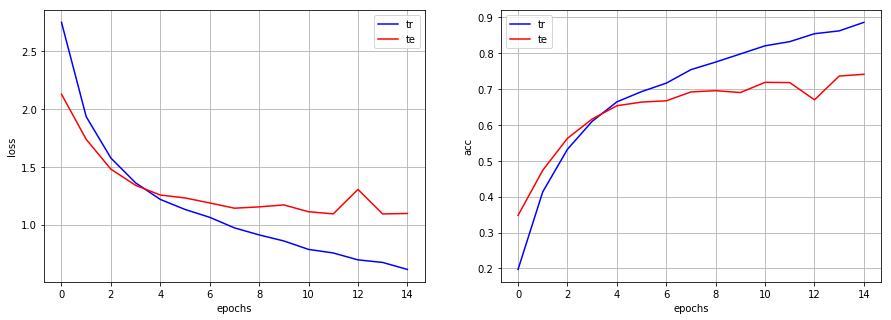

In [137]:
import matplotlib.pyplot as plt

# Visualise the training resuls.
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history["loss"], color="b", label="tr")
plt.plot(history.history["val_loss"], color="r", label="te")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(history.history["acc"], color="b", label="tr")
plt.plot(history.history["val_acc"], color="r", label="te")
plt.ylabel("acc")
plt.xlabel("epochs")
plt.grid()
plt.legend()
plt.show()

## 4. Evaluation.

In [138]:
# Obtain the predictions for the evaluation set.
y_pred = model.predict(x_val)

In [129]:
# Handle the predictions.
y_pred = np.eye(y_val.shape[1])[np.argmax(y_pred, axis=1).reshape(-1)]

In [130]:
# Display the classification report.
print(classification_report(y_val, y_pred, target_names=list(labels_index.keys()), digits=4))

                          precision    recall  f1-score   support

             alt.atheism     0.8133    0.6683    0.7337       202
           comp.graphics     0.8835    0.5260    0.6594       173
 comp.os.ms-windows.misc     0.8580    0.6651    0.7493       209
comp.sys.ibm.pc.hardware     0.7500    0.1981    0.3134       212
   comp.sys.mac.hardware     0.4485    0.8927    0.5971       205
          comp.windows.x     0.6736    0.8717    0.7599       187
            misc.forsale     0.7934    0.8667    0.8284       195
               rec.autos     0.9087    0.9356    0.9220       202
         rec.motorcycles     0.9409    0.9227    0.9317       207
      rec.sport.baseball     0.9340    0.9474    0.9406       209
        rec.sport.hockey     0.9909    0.9732    0.9820       224
               sci.crypt     0.8283    0.8817    0.8542       186
         sci.electronics     0.6825    0.8152    0.7430       211
                 sci.med     0.9421    0.9227    0.9323       194
         